# Transpile with pass managers

The recommended way to transpile a circuit is to create a staged pass manager and then execute its `run` method with the circuit as input. This page explains how to transpile quantum circuits this way.

## What is a (staged) pass manager?

In the context of Qiskit, transpilation refers to the process of transforming an input circuit into a form that is suitable for execution on a quantum device. Transpilation typically occurs in a sequence of steps called transpiler passes. The circuit is processed by each transpiler pass in sequence, with the output of one pass becoming the input to the next. For example, one pass could go through the circuit and merge all consecutive sequences of single-qubit gates, and then the next pass could synthesize these gates into the basis set of the target device. The transpiler passes included with Qiskit are located in the [qiskit.transpiler.passes](/api/qiskit/transpiler_passes) module.

A pass manager is an object that stores a list of transpiler passes and can execute them on a circuit. You create a pass manager by initializing a [PassManager](/api/qiskit/qiskit.transpiler.PassManager) with your list of transpiler passes. To run the transpilation on a circuit, call the [run](/api/qiskit/qiskit.transpiler.PassManager#run) method with your circuit as input.

A staged pass manager is a special kind of pass manager that represents a level of abstraction above that of a normal pass manager. While a normal pass manager is composed of a number of transpiler passes, a staged pass manager is composed of a number of *pass managers*. This is a useful abstraction because transpilation is typically happens in discrete stages, as described in [Transpiler stages](transpiler-stages), with each stage being represented by a pass manager. The rest of this page will describe how to create and customize (staged) pass managers.

## Generate a preset staged pass manager

To create a preset staged pass manager with reasonable defaults, use the [`generate_preset_pass_manager`](/api/qiskit/transpiler_preset#qiskit.transpiler.preset_passmanagers.generate_preset_pass_manager) function:

In [1]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend)

See [Transpilation defaults and configuration options](defaults-and-configuration-options) for a description of the possible arguments to the `generate_preset_pass_manager` function.

If the preset pass managers don't fulfill your needs, you can customize transpilation by creating your own (staged) pass managers or even your own transpilation passes. The rest of this page describes how to create pass managers. For instructions to create transpilation passes, see [Write your own transpilation pass](write-your-own-transpilation-pass).

## Create your own pass manager

The [qiskit.transpiler.passes](/api/qiskit/transpiler_passes) module includes many transpiler passes that you can use to create pass managers. To create a pass manager, initialize a `PassManager` with a list of passes. For example, the following code creates a transpiler pass that merges adjacent two-qubit gates and then synthesizes them into a basis of [$R_y$](/api/qiskit/qiskit.circuit.library.RYGate), [$R_z$](/api/qiskit/qiskit.circuit.library.RZGate), and [$R_{xx}$](/api/qiskit/qiskit.circuit.library.RXXGate),  gates.

In [2]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import (
    Collect2qBlocks,
    ConsolidateBlocks,
    UnitarySynthesis,
)

basis_gates = ["rx", "ry", "rxx"]
translate = PassManager(
    [
        Collect2qBlocks(),
        ConsolidateBlocks(basis_gates=basis_gates),
        UnitarySynthesis(basis_gates),
    ]
)

To demonstrate this pass manager in action, test it on a two-qubit circuit consisting of a Hadamard followed by two adjacent CX gates:

/home/kjs/.local/share/virtualenvs/scratch-h4kO_6N_/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


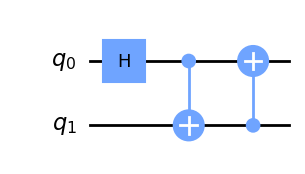

In [3]:
from qiskit import QuantumRegister, QuantumCircuit

qubits = QuantumRegister(2, name="q")
circuit = QuantumCircuit(qubits)

a, b = qubits
circuit.h(a)
circuit.cx(a, b)
circuit.cx(b, a)

circuit.draw("mpl")

To run the pass manager on the circuit, call the `run` method.

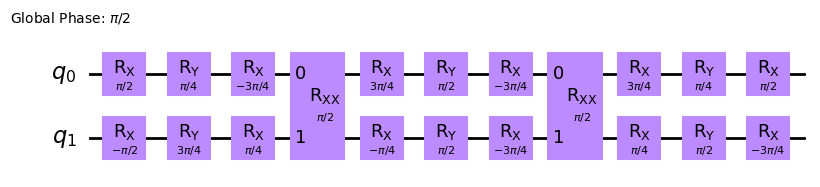

In [4]:
translated = translate.run(circuit)
translated.draw("mpl")

## Create a staged pass manager

A `StagedPassManager` is a pass manager that is composed of individual stages, where each stage is defined by a `PassManager` instance. You can create a `StagedPassManager` by specifying the desired stages. For example, the following code creates a staged pass manager with two stages, `init` and `translation`. The `translation` stage is defined by the pass manager that was created previously.

In [5]:
from qiskit.transpiler import PassManager, StagedPassManager
from qiskit.transpiler.passes import UnitarySynthesis, Unroll3qOrMore

basis_gates = ["rx", "ry", "rxx"]
init = PassManager([UnitarySynthesis(basis_gates, min_qubits=3), Unroll3qOrMore()])
staged_pm = StagedPassManager(
    stages=["init", "translation"], init=init, translation=translate
)

There is no limit on the number of stages you can put in a staged pass manager.

Another useful way to create a staged pass manager is to begin with a preset staged pass manager and then swap out some of the stages. For example, the following code generates a preset pass manager with optimization level 3, and then specifies a custom `pre_layout` stage.

In [6]:
import numpy as np
from qiskit.circuit.library import HGate, PhaseGate, RXGate, TdgGate, TGate
from qiskit.transpiler.passes import CXCancellation, InverseCancellation

pass_manager = generate_preset_pass_manager(3, backend)
inverse_gate_list = [
    HGate(),
    (RXGate(np.pi / 4), RXGate(-np.pi / 4)),
    (PhaseGate(np.pi / 4), PhaseGate(-np.pi / 4)),
    (TGate(), TdgGate()),
]
logical_opt = PassManager(
    [
        CXCancellation(),
        InverseCancellation(inverse_gate_list),
    ]
)

# Add pre-layout stage to run extra logical optimization
pass_manager.pre_layout = logical_opt

The [stage generator functions](/api/qiskit/transpiler_preset#stage-generator-functions) might be useful for constructing custom pass managers.
They generate stages that provide common functionality used in many pass managers.
For example, [`generate_embed_passmanager`](/api/qiskit/transpiler_preset#qiskit.transpiler.preset_passmanagers.common.generate_embed_passmanager) can be used to generate a stage
to "embed" a selected initial `Layout` from a layout pass to the specified target device.

## Create a pass manager for dynamical decoupling

This section demonstrates how to use the [`PadDynamicalDecoupling`](/api/qiskit/qiskit.transpiler.passes.PadDynamicalDecoupling) pass to add an error suppression technique called _dynamical decoupling_ to the circuit.
Dynamical decoupling works by adding pulse sequences (known as _dynamical decoupling sequences_) to idle qubits to flip them around the Bloch sphere, which chancels the effect of noise channels, thereby suppressing decoherence. These pulse sequences are similar to refocusing pulses used in nuclear magnetic resonance. For a full description, see [A Quantum Engineer's Guide to Superconducting Qubits](https://arxiv.org/abs/1904.06560).

Because the `PadDynamicalDecoupling` pass only operates on scheduled circuits and involves gates that are not necessarily basis gates of our target, you will need the [`ALAPScheduleAnalysis`](/api/qiskit/qiskit.transpiler.passes.ALAPScheduleAnalysis) and [`BasisTranslator`](/api/qiskit/qiskit.transpiler.passes.BasisTranslator) passes as well.

This example uses `ibm_brisbane`, which was initialized previously. Get the `target` information from the `backend` and save the operation names as `basis_gates` because the `target` will need to be modified to add timing information for the gates used in dynamical decoupling.

In [7]:
target = backend.target
basis_gates = list(target.operation_names)

Create an `EfficientSU2` circuit as an example. First, transpile the circuit to the backend because dynamical decoupling pulses need to be added after the circuit has been transpiled and scheduled. Dynamical decoupling often works best when there is a lot of idle time in the quantum circuits - that is, there are qubits that are not being used while others are active. This is the case in this circuit because the two-qubit `ecr` gates are applied sequentially in this ansatz.

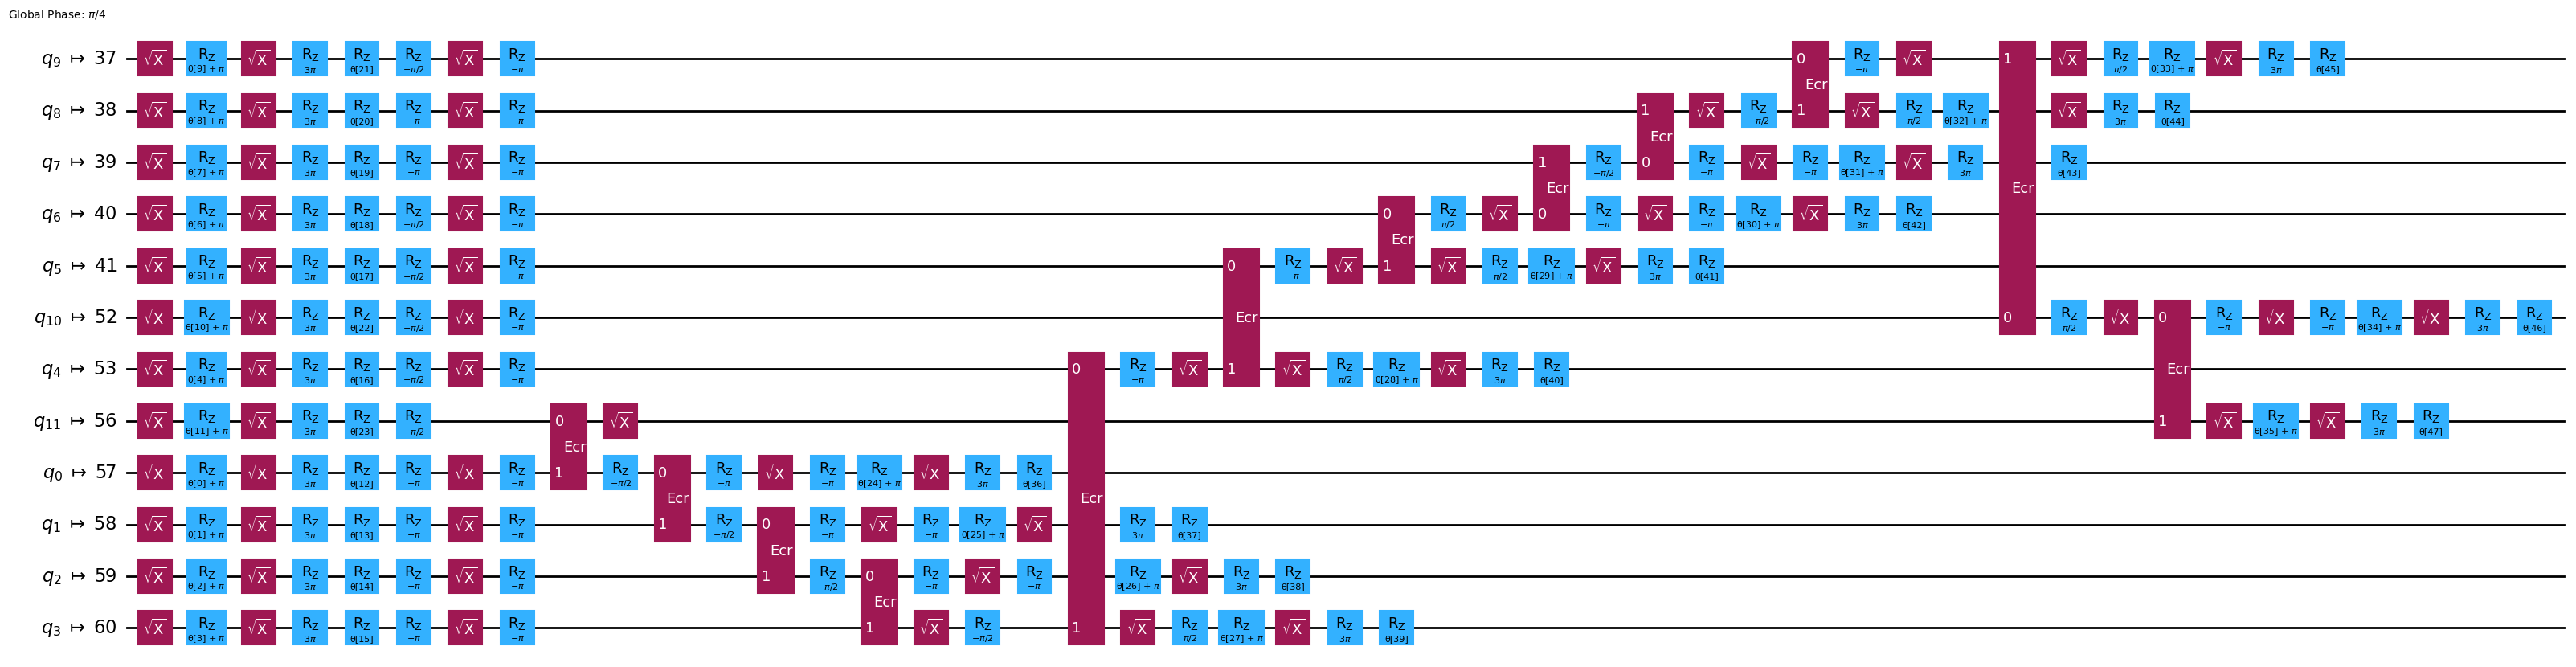

In [8]:
from qiskit import transpile
from qiskit.circuit.library import EfficientSU2

qc = EfficientSU2(12, entanglement="circular", reps=1)
qc_t = transpile(qc, target=target, seed_transpiler=12345)
qc_t.draw("mpl", style="iqp", fold=-1, idle_wires=False)

A dynamical decoupling sequence is a series of gates that compose to the identity and are spaced regularly in time. For example, start by creating a simple sequence called XY4 consisting of four gates.

In [9]:
from qiskit.circuit.library import XGate, YGate

X = XGate()
Y = YGate()

dd_sequence = [X, Y, X, Y]

Because of the regular timing of dynamical decoupling sequences, information about the `YGate` must be added to the `target` because it is *not* a basis gate, whereas the `XGate` is. We know *a priori* that the `YGate` has the same duration and error as the `XGate`, however, so we can just retrieve those properties from the `target` and add them back for the `YGate`s. This is also why the `basis_gates` were saved separately, since we are adding the `YGate` instruction to the `target` although it is not an actual basis gate of `ibm_brisbane`.

In [10]:
from qiskit.transpiler import InstructionProperties

y_gate_properties = {}
for qubit in range(target.num_qubits):
    y_gate_properties.update(
        {
            (qubit,): InstructionProperties(
                duration=target["x"][(qubit,)].duration,
                error=target["x"][(qubit,)].error,
            )
        }
    )

target.add_instruction(YGate(), y_gate_properties)

Ansatz circuits such as `EfficientSU2` are parameterized, so they must have value bound to them before being sent to the backend. Here, assign random parameters.

In [11]:
import numpy as np

rng = np.random.default_rng(1234)
qc_t.assign_parameters(rng.uniform(-np.pi, np.pi, qc_t.num_parameters), inplace=True)

Next, execute the custom passes. Instantiate the `PassManager` with `ALAPScheduleAnalysis` and `PadDynamicalDecoupling`.  Run `ALAPScheduleAnalysis` first to add timing information about the quantum circuit before the regularly-spaced dynamical decoupling sequences can be added. These passes are run on the circuit with `.run()`.

In [12]:
from qiskit.transpiler.passes.scheduling import (
    ALAPScheduleAnalysis,
    PadDynamicalDecoupling,
)

dd_pm = PassManager(
    [
        ALAPScheduleAnalysis(target=target),
        PadDynamicalDecoupling(target=target, dd_sequence=dd_sequence),
    ]
)
qc_dd = dd_pm.run(qc_t)

Use the visualization tool [`timeline_drawer`](/api/qiskit/qiskit.visualization.timeline_drawer) to see the circuit's timing and confirm that a regularly-spaced sequence of `XGate`s and `YGate`s appear in the circuit.

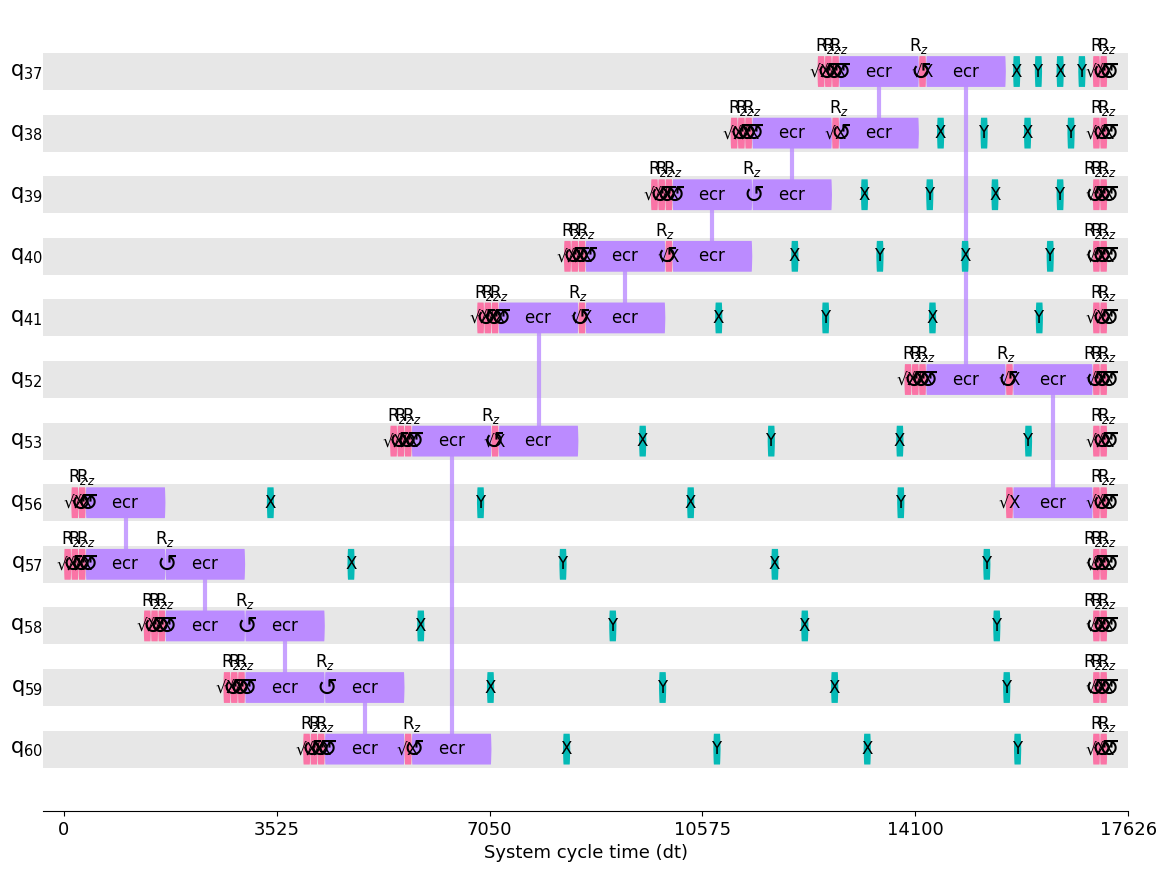

In [13]:
from qiskit.visualization import timeline_drawer

timeline_drawer(qc_dd, show_idle=False)

Lastly, because the `YGate` is not an actual basis gate of our backend, manually apply the `BasisTranslator` pass (this is a default pass, but it is executed before scheduling, so it needs to be applied again). The session equivalence library is a library of circuit equivalences that allows the transpiler to decompose circuits into basis gates, as also specified as an argument.

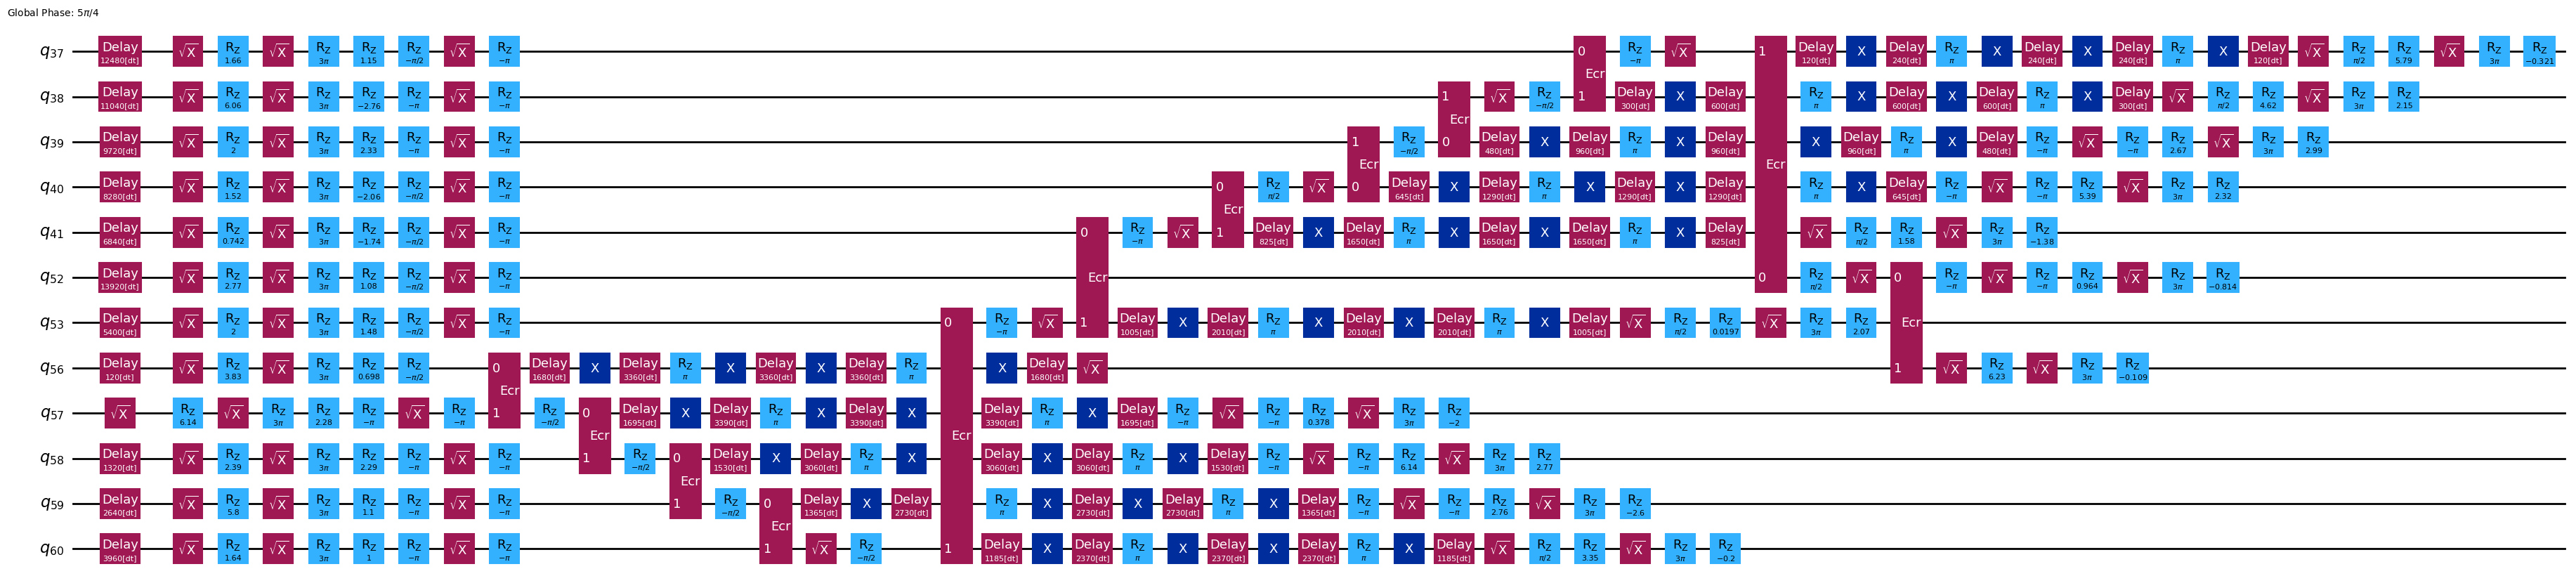

In [14]:
from qiskit.circuit.equivalence_library import SessionEquivalenceLibrary as sel
from qiskit.transpiler.passes import BasisTranslator

qc_dd = BasisTranslator(sel, basis_gates)(qc_dd)
qc_dd.draw("mpl", style="iqp", fold=-1, idle_wires=False)

Now, `YGate`s are absent from our circuit, and there is explicit timing information in the form of `Delay` gates. This transpiled circuit with dynamical decoupling can now be sent to the backend.